## Introduction

The purpose of this notebook is to learn to apply various models from my online machine learning coursework to an old problem: predicting new client acquistion resulting from OAFs growth strategy between 2017 and 2018. The ultimate goal of this exercise is to demonstrate an ability to apply the methods to produce a model that could have been used to make expansion decisions. Below is the list of various models I will be building and the refinements to the model.  Because the focus is learning while doing this it is organized in order of (real or planned) implementation.

### List of Models and Refinements:
1. Decision Tree Regressor: An implementation of the most basic decicison tree regressor model - Feb/Mar 2020.
- Selecting and Visualizing Tree Depth
- Quantifying Fit with MAE
- Visualizing predictions
- Implementation of Model in Business Context: Making Expansion Decisions
- Feature Engineering
- Questions for Further Learning
2. Random Forrest Regressor: An implementataion of the more advanced Random Forrest Regressor Model and comparison to the Decision Tree Regressor Model.
- Quantifying Fit with MAE
- Questions for Further Learning
3. XGBoost
- Quantifying Fit with MAE
- Questions for Further Learning
4. Implementation of Best Model with Geospatial Data
- Comparison of various models.
- Incorporating Geospatial Data
5. References and Credit

## Decision Tree Regressor Model ## 

In [1]:
# Predictive Models for Expansion Site Selection
# By: Sarvottam Salvi

#### Importing libraries and files ####

#Libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
#import matplotlib.pyplot as plt

# SK learn functions.
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Cleaned Ward Level Data Set:
WardData = pd.read_csv('C:/Users/Mangala Salvi/Documents/backup/Job Application Materials/GitHub Project Documents/OAF Expansion and FO Hiring/Inward Growth/Analysis/Data/Cleaned Data/IG Ward Level Dataset.csv')


# Converting DistrictName variable into categorical variable for regression. 
DensityData = WardData[['LR2018NetClientGain','LR2017ClientDensity','IGSitesDummy', 'TotalLR2017SitesinWard', 'DistrictName']]

# Creating dummy variables for district allocation of the ward.
DensityData = pd.concat((DensityData, pd.get_dummies(DensityData['DistrictName'], drop_first=True)), axis=1)
del DensityData['DistrictName']

# Selecting the variables for regression:
# Setting variables as target and predictors: Can do this to increase readability
IndpVar = DensityData.iloc[:,1:]
#IndpVar = sm.add_constant(IndpVar)
DepVar = DensityData[["LR2018NetClientGain"]]


#### ML Prediction Methods ####

### 1. Decision Tree Regressor Model ####

## Creating Model Dataset & Asssigning Dep, independent.

DensityModel = WardData[['LR2018NetClientGain','LR2017ClientDensity','IGSitesDummy', 'TotalLR2017SitesinWard', 'DistrictName']]

# Turning density range into dummy variable to avoid extrapolation.
# Don't need to cut density model into buckets.
#DensityModel['LR2017ClientDensity'] = pd.cut(DensityModel['LR2017ClientDensity'],5)
#DensityModel = pd.concat((DensityModel, pd.get_dummies(DensityModel['LR2017ClientDensity'], drop_first=True)), axis=1)
DensityModel = pd.concat((DensityModel, pd.get_dummies(DensityModel['DistrictName'], drop_first=True)), axis=1)

del DensityModel['LR2017ClientDensity']
del DensityModel['DistrictName']

IndpVar = DensityModel.iloc[:,1:]
#IndpVar = sm.add_constant(IndpVar)
DepVar = DensityModel[["LR2018NetClientGain"]]

## Randomly creating training and testing datasets:
train_X, val_X, train_y, val_y = train_test_split(IndpVar, DepVar, random_state=1)

# Creating the Decision Regressor Model
# Specify Model
DTRegNetClientGain = DecisionTreeRegressor(random_state=1)
# Fit Model
DTRegNetClientGain.fit(train_X, train_y)


DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=1, splitter='best')

#### Selecting and Visualizing Tree Depth

In the code below I calculate the MAE for various tree depths and show which tree depth was chosen to minimize MAE and the risk of overfitting.

Validation MAE without Setting Max Leaf Nodes: 259


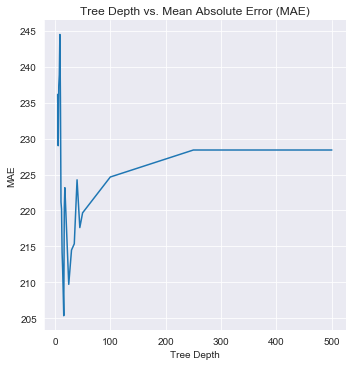

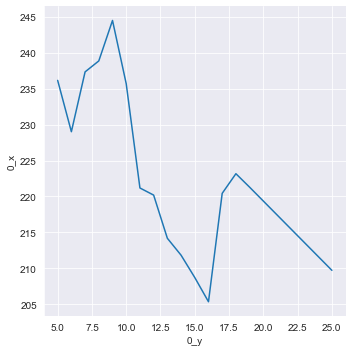

In [2]:
# Make validation predictions and calculate mean absolute error
DTRegNetClientGain_predictions = DTRegNetClientGain.predict(val_X)
DTRegNetClientGain_mae = mean_absolute_error(DTRegNetClientGain_predictions, val_y)
print("Validation MAE without Setting Max Leaf Nodes: {:,.0f}".format(DTRegNetClientGain_mae))

# Defining Function for Checking MAEs at different # of Nodes:
def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=0)
    model.fit(train_X, train_y)
    DTRegNetClientGain_predictions = model.predict(val_X)
    mae = mean_absolute_error(val_y, DTRegNetClientGain_predictions)
    return(mae)

## Setting Max Leaf Nodes Options and Testing:
# How did I decide these were good # of nodes to check.

candidate_max_leaf_nodes = list(range(5, 20))
Other = [25,30,35,40,45,50,100,250,500]
candidate_max_leaf_nodes = candidate_max_leaf_nodes + Other
mae_list = []
# Write loop to find the ideal tree size from candidate_max_leaf_nodes
for nodes in candidate_max_leaf_nodes:
    mae = get_mae(nodes, train_X, val_X, train_y, val_y)
    mae_list.append(mae)

# Store the best value of max_leaf_nodes: Seems to be 25 in this case.
best_tree_size =  candidate_max_leaf_nodes[mae_list.index(min(mae_list))]


# Plotting MAE vs. tree depth
# Converting lists to dataframes:
mae_df = pd.DataFrame(mae_list)
depth_df = pd.DataFrame(candidate_max_leaf_nodes)

# Merging columns by row index.
TreeDepthMAE = mae_df.merge(depth_df, left_index=True, right_index=True)

# Plotting Line graph of MAE vs. Depth.
sns.set_style("darkgrid")
Full = sns.relplot(x='0_y', y='0_x', kind="line", data=TreeDepthMAE)
#Zoom = sns.relplot(x='0_y', y='0_x', kind="line", data=TreeDepthMAE.head(n=16))

# Setting Axis Labels and titles
Full.set(xlabel='Tree Depth', ylabel='MAE', title = 'Tree Depth vs. Mean Absolute Error (MAE)')

From this plot of Tree Depth and MAE we see that MAE is lowest somwhere between 5 and 20 nodes. Below I have plotted the MAE within this narrower range and we see that the optimal tree depth is 16 leaf nodes. Therefore the final model trained on all of the data will use 16 leaf nodes as the tree depth.

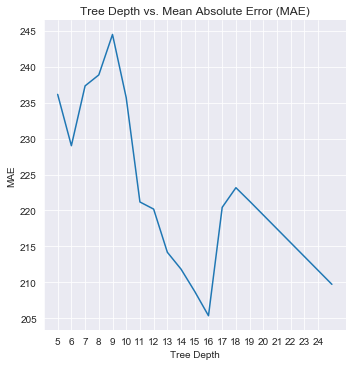

In [3]:
Zoom = sns.relplot(x='0_y', y='0_x', kind="line", data=TreeDepthMAE.head(n=16))

# Setting Axis Labels and titles
Zoom.set(xlabel='Tree Depth', ylabel='MAE', title = 'Tree Depth vs. Mean Absolute Error (MAE)')

Zoom.set(xticks= np.arange(5,26,1))

#### Implementation of Model for Site Selection Decisions:
Now that we have an ideal tree depth I have to actually use this model to generate expansion recommendations that would have been useful in that business context.  This section shows my thought on how to use a trained model to produce actionable recommendations to solve a real business problem.

Problem: How to use the decision tree regressor model to produce a list of recommended locations for hiring additional staff to maximize new client acquisition in the following year within constraints of budget and managerial capacity that limit the maximum total number of new to 500.   

In [4]:
### Checking MAE vs. Average Net Client gain

## Fitting using all data and best value of nodes:
final_NCG = DecisionTreeRegressor(max_leaf_nodes=best_tree_size, random_state = 1)

# fit the final model and uncomment the next two lines
final_NCG.fit(IndpVar, DepVar)

## Calculating Final MAE:
final_NCG_predictions = final_NCG.predict(IndpVar)